# Imports

In [1]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import Parameters
from IPython import display

CPU times: total: 4.48 s
Wall time: 5.44 s


# Model diagram

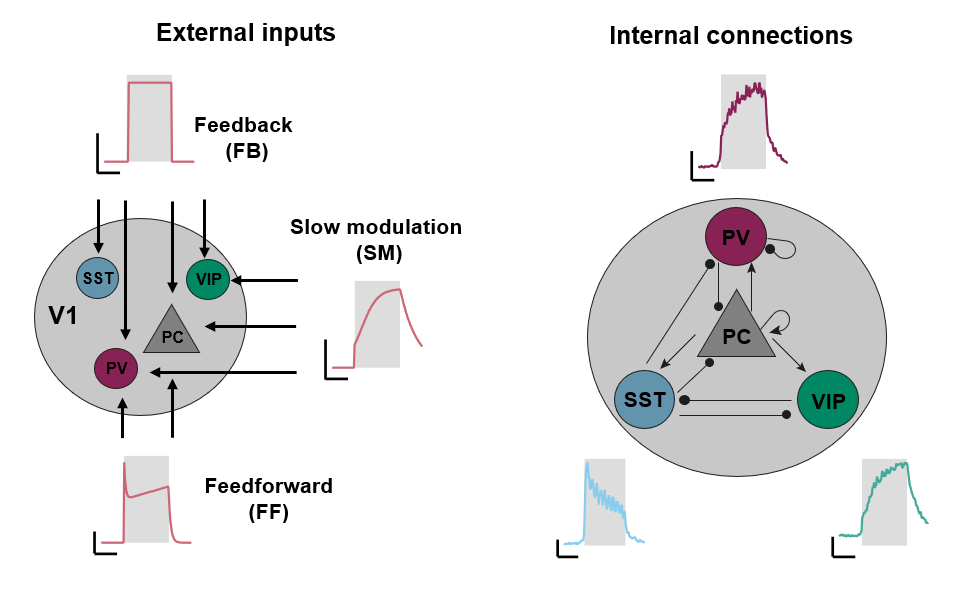

In [2]:
display.Image(r'Model_diagram.png')

# Functions

In [3]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 0, delay = 0, decay_f = 0):
    """
    Feedback (FB) input:
    ------------------------------------
    Represented as a step function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)             - time in seconds;
    stim (fixed) = 5 s      - time of the stimulus start;
    inter (fixed) = 10 s    - duration of the stimulus;
    amp (fixed) = 1.0 Hz    - amplitude of response;
    base (fixed) = 0 Hz     - baseline activity;
    k (fixed) = 0           - slope of the slow component. Used to be varied while testing linear depression or sensitization component in the FB input;
    delay (variable)        - delay of the FB input to the cell relative to the stimulus start;

    """
    
    if (t < stim + delay):
        h = base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [4]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0):
    """
    Slow Sensitizing (SS) input:
    ------------------------------------
    Represented as a sigmoid function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (fixed) = 1.0 Hz     - amplitude of response;
    base (fixed) = 0 Hz       - baseline activity;
    rate (variable)           - time-constant of the SS input;
    delay (variable)          - shift of the sigmoid center relative to stimulus start;
    decay_s (varaible)        - time-constant of the SS input exponential decay after the end of stimulation;

    """
    
    if (t < stim):
        h = base
    elif (t > stim + inter):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [5]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    """
    Feedforward (FF) input:
    ------------------------------------
    Represented as a flat step function with fast exponential decay on the stimulus start and linear increase during 10 second period. 
    Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (variable)           - amplitude of peak;
    base (fixed) = 1 Hz       - steady-state firing rate after fast exponential depression;
    decay (variable)          - time-constant of the fast exponential depression;
    delay (variable)          - delay of the FF input to the cell relative to the stimulus start;
    b (fixed) = 0 Hz          - baseline activity;
    decay_ff (varaible)       - time-constant of the FF input exponential decay after the end of stimulation;
    s_start (varaible)        - delay after stimulus when linear modulation starts;
    k (varaible)              - slope of the slow linear modulation;

    """
    
    if (t < stim + delay):
        h = b
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [ ]:
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
               i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5):
    """
    Model basis:
    ------------------------------------
    Systems of first order differential equations that captures activity of populations(df_xdt). 
    Returns an array of values of the derrivatives at a certain timepoint, calculated from values of functions in previous timepoint. 
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    y (running)               - values of activities on the previous timepoint;
    w_x (variable)            - synaptic weights;
    tau_x (fixed)             - neurons time-constants;
    threshold (fixed) = 0 Hz  - minimum rectification value;
    power (fixed) = 2         - value of the power in the input-output function;
    q (fixed) = 1             - normalization coeficient in the input-output function;
    i_x (variable)            - baseline activity of neurons;
     i_d_0, w_d_1-5           - are variables that correspond to PC subpopulation
    ...
    
    """
    
            
    f_e, f_e_d, f_p, f_s, f_v = y
    
    ## Model equations
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_d_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_d_3 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    

    dydt = [df_edt, df_e_ddt, df_pdt, df_sdt, df_vdt]
    
    return dydt

In [7]:
Type = 'Sen'
names = ['w_PC_PC', # w_d_0
         'w_FF_PC', # w_d_1
         'w_SS_PC', # w_d_2
         'w_FB_PC', # w_d_3
         'w_PV_PC', # w_d_4
         'w_SST_PV'] # w_d_5

In [8]:
def exp_time(start, step, count, endpoint=False):
    """
    Experimental timepoints calculation:
    ------------------------------------
    Returns an array of values of the experimental timepoints. 
    ------------------------------------
    Parameters:
    
    start              - starting point;
    step               - value of time step of experimental recordings;
    count              - number of points;
    
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [9]:
def odesol_step(tt, init, params): 
    """
    Solves differential equation system defined in model_step() function.
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value
    
    i_d_0 = params['i_d_0'].value
    w_d_0 = params['w_d_0'].value
    w_d_1 = params['w_d_1'].value
    w_d_2 = params['w_d_2'].value
    w_d_3 = params['w_d_3'].value
    w_d_4 = params['w_d_4'].value
    w_d_5 = params['w_d_5'].value
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
                                            i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                   )
    
    return sol

In [ ]:
def simulate_step(tt, init, params):
    """
    Model simulation:
    ------------------------------------
    Returns a Pandas DataFrame of timesteps and populational activity traces. 
    ------------------------------------
    Parameters:
    
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    """
    
    sol = odesol_step(tt, init, params)
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_e_d', 'f_pv', 'f_sst', 'f_vip'])
    
    return sim

In [11]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):
    """
    Root:Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for full fit of 4 averages of populations: PC, PV, SST, VIP. 
    ------------------------------------
    Parameters:
    
    params              - Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """
    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

# Experimental data

In [12]:
#timepoint
dt = 0.164745

# PC_average (whole population)
pc_all = np.loadtxt(r'Experimental data\QA_Nor_PC_All_AvgSess1.txt')

# PC_Type (Sensitizers)
pc_type = np.loadtxt(r'Experimental data\B_QA_Norx2_Sen_Avg1_Loco.txt')

# Experimental time calculation
t_exp_1 = exp_time(start=0.0, step=dt, count=len(pc_all))

In [13]:
# PV_average (whole population)
pv = np.loadtxt(r'Experimental data\QA_Nor_PV_AvgSess.txt')

# Experimental time calculation
t_pv_exp_1 = exp_time(start=0.0, step=dt, count=len(pv))

In [14]:
# SST_average (whole population)
sst = np.loadtxt(r'Experimental data\QA_Nor_SST_AvgSess.txt')

# Experimental time calculation
t_sst_exp_1 = exp_time(start=0.0, step=dt, count=len(sst))

In [15]:
# VIP_average (whole population)
vip = np.loadtxt(r'Experimental data\QA_Nor_VIP_AvgSess.txt')

# Experimental time calculation
t_vip_exp_1 = exp_time(start=0.0, step=dt, count=len(vip))

In [16]:
# Inicialization of new arrays to cut traces for suitable range

t_exp_1_new = []
pv_new = []
sst_new = []
vip_new = []
pc_all_new = []
pc_type_new = []

# Cutting the traces
for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_all_new.append(pc_all[ind])
        pc_type_new.append(pc_type[ind])

# Adjusting for a missing initial point after deconvolution
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_type_new.insert(0, pc_type_new[0])

t_exp_1_new.append(t_exp_1_new[-1] + dt)

# Model parameters

In [17]:
# =========================================================
#             Setting working parameters
# =========================================================

#Fixed parameters

t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0)
power = np.float32(2.0)
q = np.float32(1.0)
ampl_1 = 1.0
r_1 = np.float32(1.713939)
delay_1 = np.float32(0.1650418)
delay_2 = np.float32(1.73305)
delay_3 = np.float32(0.3695274)
decay = np.float32(3.324089)
decay_s = np.float32(0.237619296)
decay_f = np.float32(0.622169296)
decay_ff = np.float32(2.820509013)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.1835884)
init = np.float32(np.array([0.055, 0.0296, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))

#Variable parameters

k = np.float32(0.017106345)
i = np.float32(np.array([0.279667994, 0.022913393, 0.197861534, 0.508132605]))
scale = np.sqrt(np.float32(np.array(pc_type_new))[30:90].mean()/np.float32(np.array(pc_all_new))[30:90].mean())
i_d = np.array([i[0] * scale])
w = np.float32(np.array([
              0.23275, # w_0  PC  -> PC        
              1.849133, # w_1  FF  -> PC
              0.344833, # w_2  SS   -> PC
              1.741779, # w_3  PV -> PC
              1.12492, # w_4  SST  -> PC
              0.839306, # w_5  PC   -> PV
              1.487947, # w_6  FF  -> PV
              1.641957, # w_7  SS -> PV
              1.830596, # w_8  PV   -> PV
              1.092395, # w_9  SST  -> PV
              0.859853, # w_10 PC -> SST
              0.419076, # w_11 FB  -> SST
              0.141826, # w_12 VIP  -> SST
              0.194661, # w_13 PC  -> VIP
              0.154939, # w_14 SST  -> VIP
              0.653488, # w_15 SS  -> VIP
              1.824916, # w_16 FB  -> PC
              1.032527, # w_17 FB  -> PV
              0.29989]))# w_18 FB -> VIP

w_d = np.array([w[0] * scale, # w_d_0  PC  -> PC        
                2.064495958, # w_d_1  FF  -> PC
                0.378838947, # w_d_2  SS   -> PC
                1.987212768, # w_d_3  FB   -> PC
                1.790674821, # w_d_4  PV   -> PC
                1.411625821]) # w_d_5  SST -> PC

data_pv = np.float32(np.array(pv_new)) 
data_sst = np.float32(np.array(sst_new)) 
data_vip = np.float32(np.array(vip_new)) 
data_pc_all = np.float32(np.array(pc_all_new))
data_pc_type = np.float32(np.array(pc_type_new))

count = 0

In [18]:
# ============================
#     Parameter definition
# ============================

params = Parameters()
params.add('w_0', value = w[0])
params.add('w_1', value = w[1])
params.add('w_2', value = w[2])
params.add('w_3', value = w[3])
params.add('w_4', value = w[4])
params.add('w_5', value = w[5])
params.add('w_6', value = w[6])
params.add('w_7', value = w[7])
params.add('w_8', value = w[8])
params.add('w_9', value = w[9])
params.add('w_10', value = w[10])
params.add('w_11', value = w[11])
params.add('w_12', value = w[12])
params.add('w_13', value = w[13])
params.add('w_14', value = w[14])
params.add('w_15', value = w[15])
params.add('w_16', value = w[16])
params.add('w_17', value = w[17])
params.add('w_18', value = w[18])

params.add('tau_0', value = tau[0])
params.add('tau_1', value = tau[1])
params.add('tau_2', value = tau[2])
params.add('tau_3', value = tau[3])
params.add('threshold', value = threshold)
params.add('power', value = power)
params.add('q', value = q)
params.add('i_0', value = i[0])
params.add('i_1', value = i[1])
params.add('i_2', value = i[2])
params.add('i_3', value = i[3])

params.add('ampl_1', value = ampl_1)
params.add('r_1', value = r_1)
params.add('delay_1', value = delay_1)
params.add('delay_2', value = delay_2)
params.add('delay_3', value = delay_3)
params.add('decay', value = decay)
params.add('decay_s', value = decay_s)
params.add('decay_f', value = decay_f)
params.add('decay_ff', value = decay_ff)
params.add('ampl', value = ampl)
params.add('base', value = base)
params.add('base_sigm', value = base_sigm)
params.add('s_start', value = s_start)
params.add('k', value = k)

params.add('i_d_0', value = i_d[0])
params.add('w_d_0', value = w_d[0])
params.add('w_d_1', value = w_d[1])
params.add('w_d_2', value = w_d[2])
params.add('w_d_3', value = w_d[3])
params.add('w_d_4', value = w_d[4])
params.add('w_d_5', value = w_d[5])

## Model Simulation

### Connection weights to sensitizers (wji)

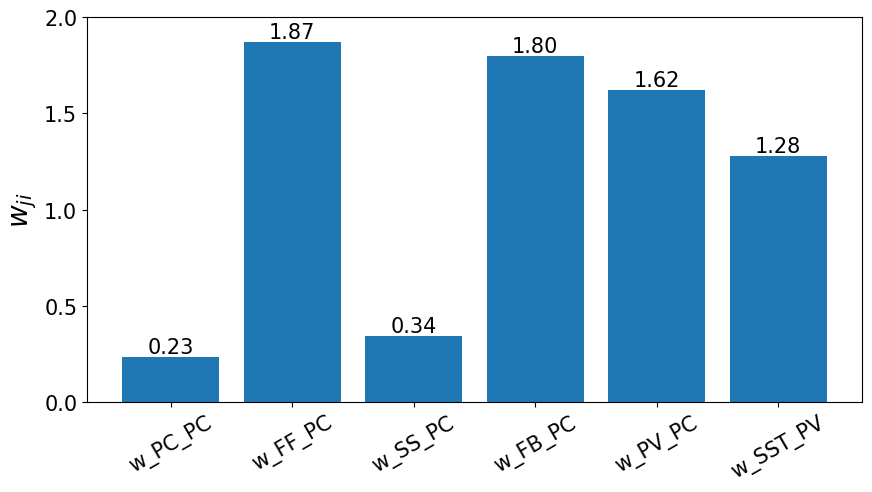

Scale = 1.1043589


In [19]:
vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(10,5))
plt.ylabel(r"$w_{ji}$", fontsize=20)
plt.bar(range(len(vals[-6:])),vals[-6:]/scale, color='blue')
plt.xticks(range(len(vals[:6])), names[:6], rotation = 30, fontsize=15)
plt.bar_label(plt.bar(range(len(vals[-6:])),vals[-6:]/scale), fmt = '{:.2f}', fontsize=15)
plt.yticks(np.arange(0,2.5,0.5), fontsize=15)
plt.show()
print('Scale =',scale)

In [20]:
# Simulate the model with parameters defined in params
model = simulate_step(t_exp, init, params)

### Fitting to experimental traces

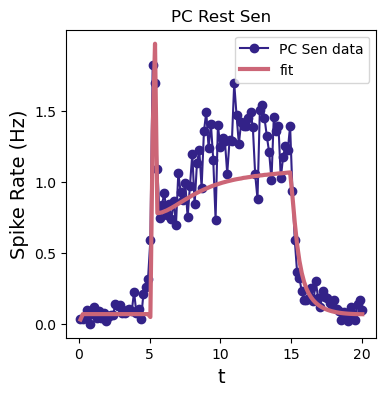

In [21]:
# ============================
#        PC Sensitizers
# ============================
plt.figure(figsize=(4,4))
plt.plot(t_exp, data_pc_type, color='#332288', marker='o', label='PC '+ Type +' data')
plt.plot(t_exp, model['f_e_d'].values, color='#cc6677', label='fit', linewidth=3)
plt.title('PC Rest '+ Type)
plt.legend(loc='best')
plt.ylabel("Spike Rate (Hz)", fontsize=14)
plt.xlabel('t', fontsize=14)
plt.xticks(np.arange(0,21,5))
plt.yticks(np.arange(0,1.7,0.5))
plt.show()

### Root mean square error calculation (RMSE)

In [22]:
a_tot = RMSE_full(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_tot)

0.10667890157371662


### Saving Traces

In [23]:
# Write csv file with output. f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y
model[['t', 'f_e_d']].to_csv('Trace_PC_Loco_'+Type+'.csv', index=False)